Extrapolate solar coronal magnetic field using the PFSS model and HMI data

In [1]:
# !jupyter lab --version

In [6]:
%matplotlib widget
# notebook, widget

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('TkAgg') # nbAgg, Qt5Agg, widget, TkAgg, Agg

import glob
import pandas as pd
import sunpy.map
from sunpy.coordinates import sun
import astropy.units as u
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, LogStretch

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'
savedir = '/home/mnedal/repos/dias_work'

In [2]:
# get the Carrington rotation number for a specific date
dt = pd.Timestamp('2024-05-14 17:40')
cr = sun.carrington_rotation_number(t=dt)
print(f'Date: {dt}\tCarrington rotation number: {cr}')

Date: 2024-05-14 17:40:00	Carrington rotation number: 2284.3029094287863


In [3]:
int(cr), round(cr)

(2284, 2284)

In [4]:
filename = download_file(
    f'http://jsoc.stanford.edu/data/hmi/synoptic/hmi.Synoptic_Mr.{int(cr)}.fits', cache=True)
syn_map = sunpy.map.Map(filename)

In [5]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=syn_map)
im = syn_map.plot(axes=ax)

ax.coords[0].set_axislabel('Carrington Longitude [deg]')
ax.coords[1].set_axislabel('Latitude [deg]')

ax.coords.grid(color='black', alpha=0.6, linestyle='dotted', linewidth=0.5)

cb = plt.colorbar(im, fraction=0.0195, pad=0.01)
cb.set_label(f"Radial magnetic field [{syn_map.unit}]")

# In order to make the x-axis ticks show, the bottom y-limit has to be adjusted slightly
ax.set_ylim(bottom=0)
ax.set_title(f"{syn_map.meta['content']}, Carrington rotation {syn_map.meta['CAR_ROT']}")
plt.show()

<IPython.core.display.Javascript object>

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [7]:
def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict



def load_aia(start=None, end=None, channel=193):
    dt_dict = split_datetime(start=start, end=end)
    data_path = f'{data_dir}/AIA/{channel}A/lv15'
    data = sorted(glob.glob(f'{data_path}/aia_{channel}a_*.fits'))
    
    start_filename = f"aia_{channel}a_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}"
    end_filename   = f"aia_{channel}a_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}"
    
    first_file_to_find = glob.glob(f'{data_path}/{start_filename}*.fits')
    last_file_to_find  = glob.glob(f'{data_path}/{end_filename}*.fits')
    
    idx1 = data.index(first_file_to_find[0])
    idx2 = data.index(last_file_to_find[0])
    
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        print(f'AIA {channel}A image {i} is loaded')
    return map_objects

In [8]:
aia_193_map_object = load_aia(start='2024-05-14T17:40:00', end='2024-05-14T17:41:00', channel=193)
print(len(aia_193_map_object))

AIA 193A image 0 is loaded
1


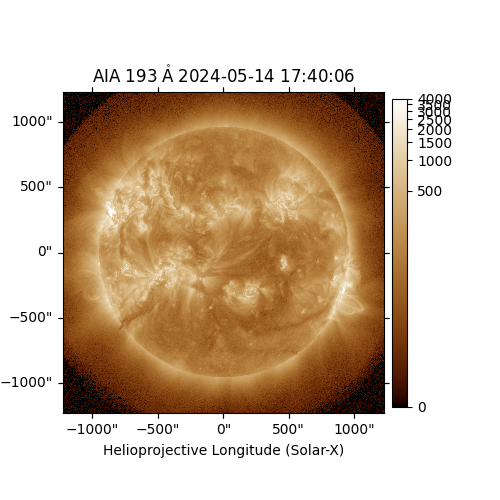

In [9]:
m = aia_193_map_object[0]
m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=LogStretch())

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111, projection=m)
img = m.plot(axes=ax)
plt.colorbar(img, shrink=0.8, pad=0.02)
ax.grid(False)
plt.show()

In [10]:
from sunkit_pyvista import SunpyPlotter

In [11]:
# Start by creating a plotter
plotter = SunpyPlotter()

# Plot a map
plotter.plot_map(aia_193_map_object[0], clip_interval=[1,99]*u.percent, assume_spherical_screen=False)

# Add an arrow to show the solar rotation axis
plotter.plot_solar_axis()

In [12]:
# plot the HMI Synoptic Map to fill in the farside
plotter.plot_map(syn_map, cmap='hmimag', clip_interval=[1,99]*u.percent)

In [ ]:


# Create points spaced between lat={-90, 90} degrees
lat = np.linspace(-np.pi / 2, np.pi / 2, 32, endpoint=False)
# Create 32 points spaced between long={0, 360} degrees
lon = np.linspace(0, 2 * np.pi, 32, endpoint=False)
# Make a 2D grid from these 1D points
lat, lon = np.meshgrid(lat, lon, indexing="ij")
# Create lon, lat and radial coordinate values by using a sunkit-magex
# and trace them using tracer
lat, lon = lat.ravel() * u.rad, lon.ravel() * u.rad
# Define the number of grid points in rho and solar surface radius
nrho = 30
rss = 1.5
input_ = pfss.Input(gong_map, nrho, rss)
output_ = pfss.pfss(input_)
seeds = SkyCoord(lon, lat, 1.2 * R_sun, frame=gong_map.coordinate_frame)
tracer = tracing.FortranTracer()
field_lines = tracer.trace(seeds, output_)